<div>
    <em><h1>Health Marketing</h1></em>
    <img width="10%" height="10%" src='pics/aiHealth_01.jpg'/>
    
    
</div>
<div>
    <p>
    <em>Stap 4:</em>
    <br>
    <em>Data interpretatie: EDA in een pipeline protoype, gemaakt door het hele team</em>
        <br>
    <em>Author: Hans Olthoff, Stephan Dekker, Frank Pieterse, Jiyoon Kim</em>
    </p>    
</div>



<style>
li{
  margin: 10px 0;
}
</style>
<h2>EDA Analysis Pipeline</h2>

<h3>Index</h3>
<ol type="I">
<li><a href='#H1'>Defining the goal/problem</a></li>  
<li><a href='#H2'>Fetching and data sanitation</a></li>  
<li><a href='#section3'>Understand and visualize the data</a></li>
<li><a href='#section4'>Analyze the data</a></li>
<li><a href='#section5'>Interpret results</a></li>
<li><a href='#section6'>Iterate and refine</a></li>
<li><a href='#section7'>Save the data of your analysis</a></li>
</ol>

---
<a id='H1'></a>
## 1. Defining the goal/problem
```What is the purpose of this analysis?  ```

Building a model that accurately can predict the lifespan based on features in the data and use that to determine the premium for life insurance in an ethical way.

In [87]:
# all libraries required for the entire EDA

from requests import get
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Samuel Norman "Sam" Seaborn is a fictional character portrayed by Rob Lowe on the television serial drama The West Wing. Hence: sns
from seaborn_qqplot import pplot
import pandas as pd
import sqlite3
import datetime as dt
from scipy import stats
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

import scipy.cluster.hierarchy as shc


%matplotlib inline
sns.set(color_codes=True)

---
<a id='H2'></a>
## 2. Fetching and data sanitation
```
- a. collect the data 
- b. check for: errors, missing values(Nan), data types(object,float,int), duplicates and other inconsistencies
- c. clean the data: remove duplicates and remove irrelevant information/columns
```

In [88]:
# collecting the data
dbName = "../rest_server_new/medisch_centrum_randstad/db.sqlite3"

# open db connection
dbConnection = sqlite3.connect(dbName)

# query db and write to pd:
dfFromDB = pd.read_sql_query(f"SELECT * FROM {'rest_api_netlify'}", dbConnection)

# close db connection
dbConnection.close()

# sql adds index column, remove in df:
df = dfFromDB.drop('id', axis=1)
pd.set_option('display.max_columns', 10)
print(df.head())

   genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar
0     73.9   185.0   99.7       0.9      0.0      2.4      73.1    6.9
1     86.0   172.0  105.4       1.8      8.1      0.4      85.0    4.2
2     83.3   176.0  111.4       1.1      0.8      4.6      81.6    7.5
3     82.8   164.0  111.4       4.7     11.8      1.0      81.0    2.9
4     78.7   178.0   71.6       1.5      8.3      4.9      75.0    5.5


In [89]:
# for collecting data in csv form:

# df_raw= pd.read_csv('data/raw_data_2.csv',skipinitialspace=True)

# print(df_raw.head())
# print()
# print(df_raw.info())

In [90]:
# # for collecting data from REST API

# # Make request to an URL
# response = requests.get('http://localhost:8080/medish_centrum_randstad/api/netlify?page=1')

# file_contents= response.json()  #dictionary
# print(type(file_contents))
# print(len(file_contents))

# df = pd.DataFrame.from_dict(file_contents['data']) #all the needed info was condensed into one data column called 'data'
# display(df.head())
# display(df.shape)

In [91]:
# df = df_raw.copy()

In [92]:
# ... select value to be looked at.

key = df.keys()

pipe = input('please type the name of the column you want to look at')
if pipe in key:
    print (f'We will be looking at "{pipe}" this time.')
else:
    print ('Please rerun this field and suply a valid column key.')

please type the name of the column you want to look at mass


We will be looking at "mass" this time.


In [93]:
# # ... get a loc  not used atm
# dx=df.columns.get_loc(pipe)
# print (dx)

In [94]:
# ... removes turns non-int/non-flo to NaN and removes NaN
# ... selects if the columns have object as dtype. 
# ... Then chance the values in the columns to numbers and coerce tot NaN if the value cant be turned into a number. 

# the df will be the old df where we apply changed with a lambda to apply pd.to_numeric where non numbers will be coerced to NaN for those columns were dtype is object.  
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)

# ... change the dtype to float 64
df.astype('float64').dtypes


genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
lifespan    float64
sugar       float64
dtype: object

Duplication Check

In [95]:
# ... a check to see if there are duplicates in the data.
# ... print the shape of the df
# ... report the duplicates and ask if you want the duplicates to be deleted. 

duplicate_rows_df = df[df.duplicated()]
print ("Number of duplicate rows: ", duplicate_rows_df.shape)

if duplicate_rows_df.shape == (0, 8):
    print ('There are no unexcpected duplicates')
else:
    print ('There are unexpected duplicates please look at the data')
    print(duplicate_rows_df)
    x=input('Do you want to delete the duplicates? Y/n') 
    if x == 'Y':
        df=df.drop_duplicates()

Number of duplicate rows:  (0, 8)
There are no unexcpected duplicates


NaN-check

In [96]:
print(df.isnull().sum())


genetic     1
length      3
mass        2
exercise    1
smoking     0
alcohol     2
lifespan    2
sugar       1
dtype: int64


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4095 non-null   float64
 1   length    4093 non-null   float64
 2   mass      4094 non-null   float64
 3   exercise  4095 non-null   float64
 4   smoking   4096 non-null   float64
 5   alcohol   4094 non-null   float64
 6   lifespan  4094 non-null   float64
 7   sugar     4095 non-null   float64
dtypes: float64(8)
memory usage: 256.1 KB


In [98]:
# #...why is it missing, is it random? : input (impute) or delete? (some decisions come later outlier analysis, but some can be taken now)
# # ... future make a selector to remove NaN


df = df.dropna()

print(df.head())
print ()
print (df.info())

   genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar
0     73.9   185.0   99.7       0.9      0.0      2.4      73.1    6.9
1     86.0   172.0  105.4       1.8      8.1      0.4      85.0    4.2
2     83.3   176.0  111.4       1.1      0.8      4.6      81.6    7.5
3     82.8   164.0  111.4       4.7     11.8      1.0      81.0    2.9
4     78.7   178.0   71.6       1.5      8.3      4.9      75.0    5.5

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4084 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   4084 non-null   float64
 1   length    4084 non-null   float64
 2   mass      4084 non-null   float64
 3   exercise  4084 non-null   float64
 4   smoking   4084 non-null   float64
 5   alcohol   4084 non-null   float64
 6   lifespan  4084 non-null   float64
 7   sugar     4084 non-null   float64
dtypes: float64(8)
memory usage: 287.2 KB
None


Check for special characters ??/>, delete and convert to int/float etc.

---
<a id='section3'></a>
## 3. Understand and visualize the data
```
- a. Examine structure and content: size,shape and type of variables
- b. Theres great value of simply looking at the data: interquartile range, mean, median etc.
- c. Visualize the data with plots: histograms, box plots, scatter plots and heatmaps
- d. Identify any outliers, patterns, relationships or trends
- e. Decide to impute or delete the outliers
- f. Identify new features

```

Structure

In [99]:
print(df.head())

   genetic  length   mass  exercise  smoking  alcohol  lifespan  sugar
0     73.9   185.0   99.7       0.9      0.0      2.4      73.1    6.9
1     86.0   172.0  105.4       1.8      8.1      0.4      85.0    4.2
2     83.3   176.0  111.4       1.1      0.8      4.6      81.6    7.5
3     82.8   164.0  111.4       4.7     11.8      1.0      81.0    2.9
4     78.7   178.0   71.6       1.5      8.3      4.9      75.0    5.5


In [100]:
print(df.dtypes)
print(df.describe()) #mean,sd, min,max

genetic     float64
length      float64
mass        float64
exercise    float64
smoking     float64
alcohol     float64
lifespan    float64
sugar       float64
dtype: object
           genetic       length         mass     exercise      smoking  \
count  4084.000000  4084.000000  4084.000000  4084.000000  4084.000000   
mean     82.278624   183.885162    92.275930     2.403477     9.809035   
std       7.441333    12.622858    25.801031     1.170426     6.918614   
min      63.900000   154.000000    50.000000     0.100000     0.000000   
25%      77.600000   175.000000    71.475000     1.500000     3.375000   
50%      81.800000   184.000000    89.500000     2.200000     9.500000   
75%      86.700000   193.000000   110.825000     3.200000    15.900000   
max     102.200000   214.000000   163.600000     5.500000    22.200000   

           alcohol     lifespan        sugar  
count  4084.000000  4084.000000  4084.000000  
mean      2.266846    80.177693     6.487169  
std       1.801044

Plots

In [101]:
#Quick Overall Graphical Overview (!warning, takes ~2min or more)
#g = sns.PairGrid(df)
#g.map(sns.lineplot)

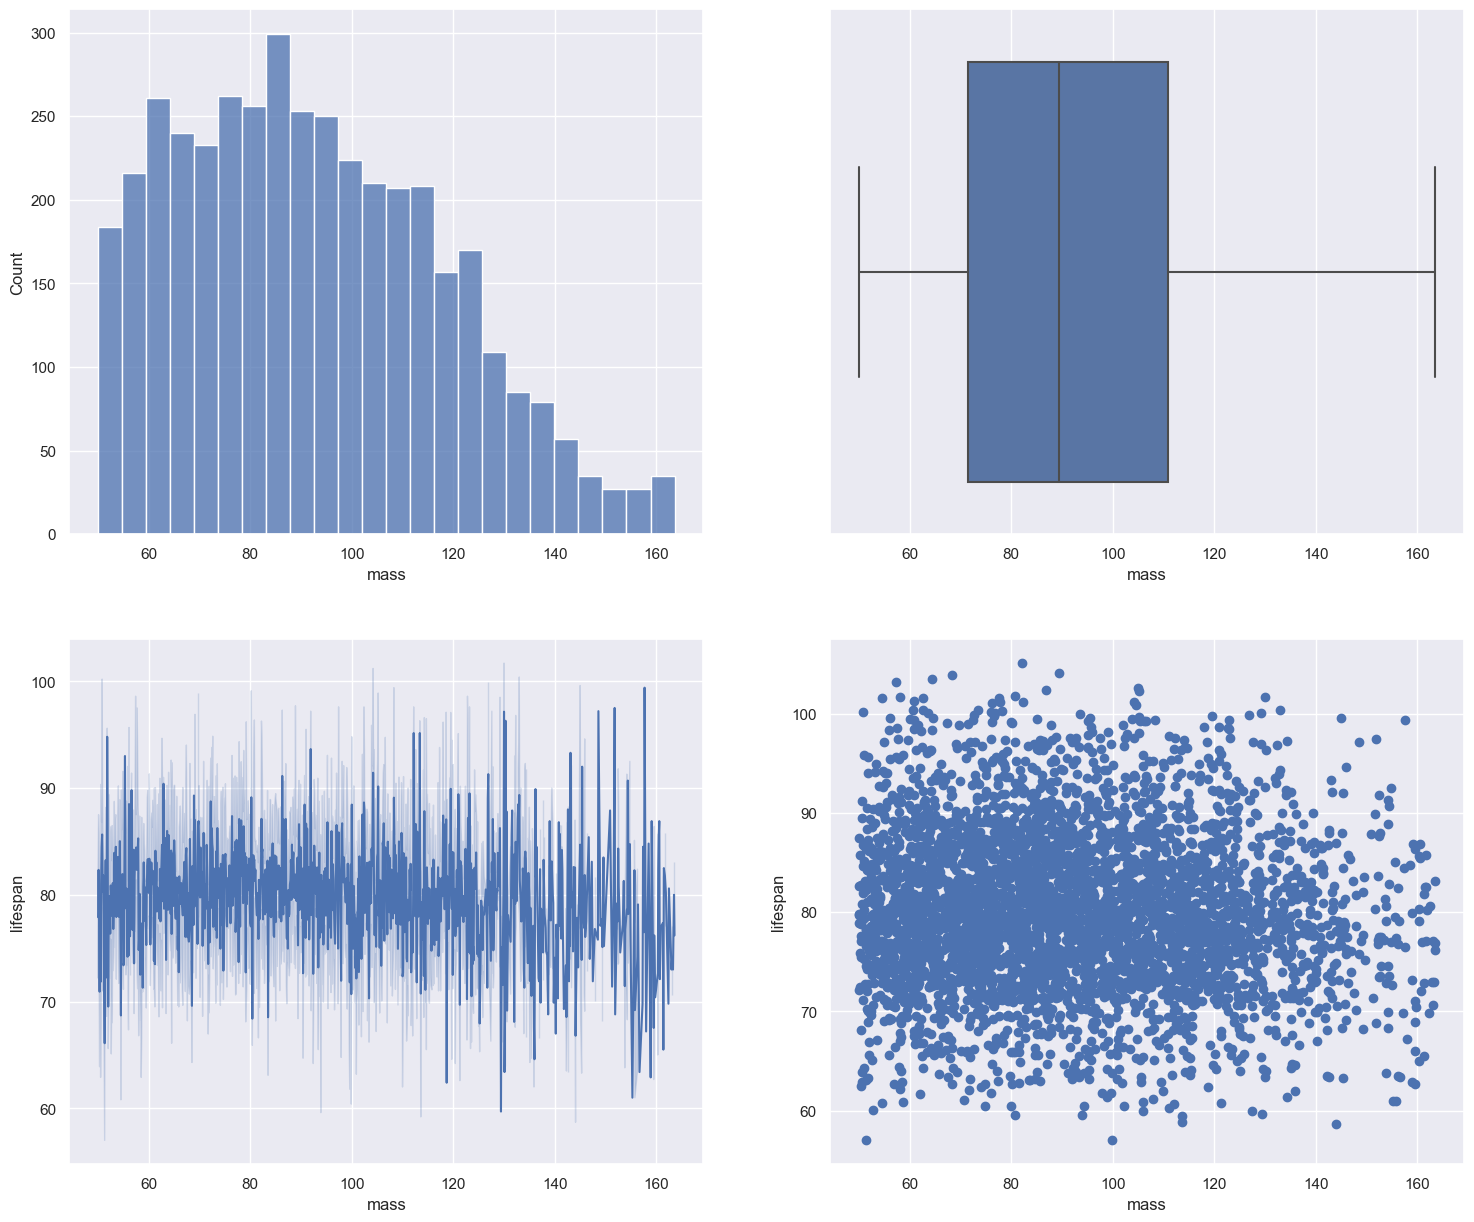

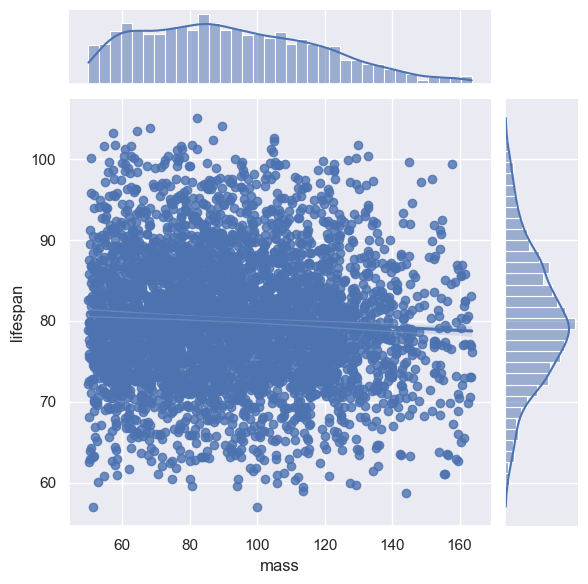

In [122]:
# Maak een raster voor 4 images

fig, axs = plt.subplots(2, 2, sharey=False, figsize=(18,15))

sns.boxplot(x=df[pipe], ax=axs[0,1])

axs[1][1].scatter(df[pipe], df['lifespan'])
axs[1][1].set_xlabel(pipe)
axs[1][1].set_ylabel('lifespan')

sns.lineplot(x=df[pipe],y=df['lifespan'], ax=axs[1,0])

sns.histplot(data=df,x=pipe, ax=axs[0,0])
# sns.catplot(data=df, x=pipe, y='lifespan', kind='box', ax=axs[1,1])


#jointplot with distribution and regression line
sns.jointplot(data=df, x=pipe, y="lifespan",marginal_kws=dict(bins=35), kind='reg')
plt.show()


__[Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__

$ \rho_{x,y} = \frac{cov(x,y)}{\sigma_{x}\sigma{y}}$


In [103]:
#colorfull matrix, showing correlations
df_corr = df.dropna().corr()
df_corr.style.background_gradient(cmap='RdBu')

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar
genetic,1.000000,-0.029606,0.000513,-0.035005,-0.015490,-0.013170,0.949799,0.018785
length,-0.029606,1.000000,0.000106,0.011401,-0.020691,-0.007162,0.013155,0.007860
mass,0.000513,0.000106,1.000000,0.008204,-0.009541,0.000726,-0.066040,0.005601
exercise,-0.035005,0.011401,0.008204,1.000000,0.021512,-0.024521,0.082986,-0.008328
smoking,-0.015490,-0.020691,-0.009541,0.021512,1.000000,-0.012298,-0.246140,0.008925
alcohol,-0.013170,-0.007162,0.000726,-0.024521,-0.012298,1.000000,-0.063539,0.003860
lifespan,0.949799,0.013155,-0.066040,0.082986,-0.246140,-0.063539,1.000000,-0.010887
sugar,0.018785,0.007860,0.005601,-0.008328,0.008925,0.003860,-0.010887,1.000000


<AxesSubplot: >

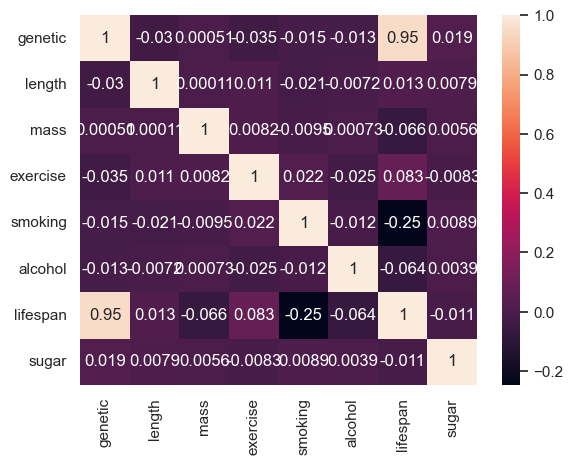

In [104]:
#graphical correlation matrix view
sns.heatmap(df_corr,annot=True)

New features:

From detailed analysis it seems logical to add bmi, and even bmi categories.
According to the WHO there is a division in 3 categories and even more sub categories.
The bmi is added to the dataframe and the code for the cats is also provided, but because lacj of time not further investigated.


In [124]:
# New Feature BMI (kg/m^2)
df['bmi'] = round(df['mass']/(df['length']/100)**2, 2)
df.head()

# bmi_cats = [0, 18.5, 25, np.inf]
# labels_bmi_cats=['underweight','normal_range','overweight']
# df['bmi_cat']= pd.cut(df['bmi'], bins=bmi_cats, labels=labels_bmi_cats)

# bmi_subcats = [0, 16, 17, 18.5, 25, 30, 35, 40, np.inf]
# labels_bmi_subcats=['severe_thinness','moderate_thinness','mild_thinness','normal', 'pre_obese', 'obese_class_I', 'obese_class_II', 'obese_class_III']
# df['bmi_subcat']= pd.cut(df['bmi'], bins=bmi_subcats, labels=labels_bmi_subcats)


# df.head(12)

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar,labels,bmi
0,73.9,185.0,99.7,0.9,0.0,2.4,73.1,6.9,76,29.13
1,86.0,172.0,105.4,1.8,8.1,0.4,85.0,4.2,-1,35.63
2,83.3,176.0,111.4,1.1,0.8,4.6,81.6,7.5,-1,35.96
3,82.8,164.0,111.4,4.7,11.8,1.0,81.0,2.9,-1,41.42
4,78.7,178.0,71.6,1.5,8.3,4.9,75.0,5.5,-1,22.60


Outliers: impute or delete?

Solution: test the regression model in the next step with different df's.

- complete cleaned df
- complete cleaned df with bmi
- complete cleaned df with bmi and clipped outliers
- complete cleaned df with bmi and dropped outliers

In [126]:
Q1=df[pipe].quantile(0.25)
print("Q1:", Q1)
Q3=df[pipe].quantile(0.75)
print("Q3:", Q3)
IQR=Q3-Q1
print("IQR: ", IQR)
lower_bound = Q1 - 1.5*IQR
print("Lower Bound:", lower_bound)
upper_bound = Q3 + 1.5*IQR
print("Upper Bound:", upper_bound)

Q1: 71.475
Q3: 110.825
IQR:  39.35000000000001
Lower Bound: 12.449999999999982
Upper Bound: 169.85000000000002


In [108]:
# Clean up outliers

#df_clean = df[(df[pipe]>lower_bound)&(df[pipe]<upper_bound)]
#sns.boxplot(y = df_clean['exercise'])


In [ ]:
# check = df[df.lifespan < 50]

# check

,genetic,length,mass,exercise,smoking,alcohol,lifespan,sugar,labels


---
<a id='section4'></a>
## 4. Analyze the data
```
- a. Apply statistical analysis tools: mean, median, mode, standard deviation
- b. Go through Checklist for linear regression: normal distribution, continuous variable, correlation and p-value
- c  Apply regression
```

<li>Calculate P-values</li>

If p<0.05 (almost 0) the correlation for the feature is extremely likely to happen again if we collect more sample data and thus representative for the entire set


In [115]:
r,p = stats.pearsonr(df.lifespan,df[pipe])
print(f'{pipe} corr:',round(r,4))
print(f'{pipe} p-val:',round(p,4))

mass corr: -0.066
mass p-val: 0.0


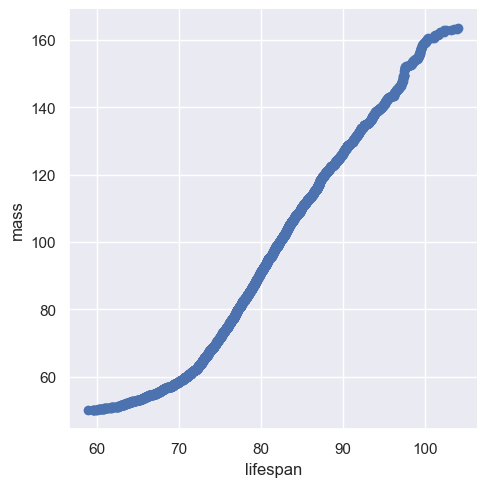

In [116]:
#Show Q-Q plot and draw conclusion on linearity and if linear regression is applicable 
from seaborn_qqplot import pplot
myplot = pplot(df, x="lifespan", y=pipe, kind='qq', height=5)

If the feature satisfies: 
 - continuous variable
 - correlation and it is linear-ish
 - normal-ish distributed 
 We can try to apply a linear regression method <br>
( e.g. in the form of
 $ y=\alpha*x_{smoking}+\beta*x_{exercise}+c $ )


In [117]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

X = train[[pipe, 'exercise']]
y = train.lifespan
regr = linear_model.LinearRegression()
regr.fit(X, y) 

LinearRegression()

In [118]:
# The coefficients
print('Coefficients: \n', regr.coef_)
print(f'c would be:',regr.predict([[0,0]]))

Coefficients: 
 [-0.02153788  0.60756582]
c would be: [80.65903152]


/home/pans/miniconda3/envs/miw/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In regression, the $R^{2}$ coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points.  <br>
Close to 1 means there is a strong correlation between the independent variables smoking, exercise and the dependent variable lifespan.

In [119]:
print(train.shape, test.shape)
score = regr.score(test[[pipe, 'exercise']],test.lifespan)
print(f'coefficient of determination(R\N{SUPERSCRIPT TWO}):', score)

(3267, 9) (817, 9)
coefficient of determination(R²): 0.003707088405428549


---
<a id='section5'></a>
## 5. Interpret the results
```
- Draw conclusions, make insights and communicate in a clear, concise and unbiased manner
```

General conclusions:
- still very few NaNs, so dropped from df
- duplicates dropped from df (there were no duplicates)
- few negative values that are invalid, so dropped from df
- strange characters converted tot NaNs and dropped

- outliers are possible good values in general, so leave them


Specific conclusions:
- all the columns have X-values and lifespan is the outcome, the y-value.
- smoking seems to have anegative impact on lifespan
- exercise seems to have a positive impact on the lifespan
- the other values seems to have less, but negative impact on the lifespan (as shown in the heatmap)

- mass: seems to have parabolic line instead of a straight line. When mass is converted to the aquare root of mass, linear regression is possible again.
- mass: maybe it can be divided into separate groups and training of the model can be done based on these groups.
- bmi: seems interesting to add, based on the results for mass.
- bmi: categories and subcategories as defined by the World Health Organization seem interesting to add. Grouping on these categories give the possibility to try clustering and look for better results per categorie. A regression per categorie is interesting but out of scope, because lack of time.


Define different sets to test for best results, when fitting the model:
* results are in the Excel sheet called _Experiment_Tracking_Management.xlsx

- df1: complete dataset without bmi
- df2: complete dataset with bmi
- df3: dataset with bmi and outliers clipped
- df4: dataset with bmi and outliers dropped

IRQ method is used to clip and drop outliers. In the end df4 has the best results.

A df6 where we used the root square of mass gives a littel better result, but because of the minimal improvement and lack of time df4 is used for the pipeline. 

---
<a id='section6'></a>
## 6. Iterate and refine
```
- Explore alternative approaches e.g. test assumptions and update your conclusions based on feedback and new insights 
```

Take the square root of the mass to make it lineair. Therefore a df6 was created.



---
<a id='section7'></a>
## 7. Save the data of your analysis
```

In [121]:
# safe the data from this notebook as a csv in the folder output 

df.to_csv('data/data_{}_{}.csv'.format(pipe,dt.datetime.now().strftime("%Y-%m-%d %H-%M")), index=False,sep=';')